<a href="https://colab.research.google.com/github/Anitasulukhia/Multi-Task-Learning-with-a-Two-Headed-MLP/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Loading data and combining into one dataframe, by default target values were
# different, so i joined every column into dataframe and will later
# divide into features and targets

student_performance = fetch_ucirepo(id=320)
data = pd.concat([student_performance.data.features, student_performance.data.targets], axis=1)

# observation for which columns are already numeric and which ones
# i should convert

# for col in data.columns:
#   print(col)
#   print(data[col].unique())

# for binary (yes, no) columns, i simply assign 1 and 0.

binary_map = {'yes': 1, 'no': 0}
data['schoolsup'] = data['schoolsup'].map(binary_map)
data['famsup'] = data['famsup'].map(binary_map)
data['paid'] = data['paid'].map(binary_map)
data['activities'] = data['activities'].map(binary_map)
data['nursery'] = data['nursery'].map(binary_map)
data['higher'] = data['higher'].map(binary_map)
data['internet'] = data['internet'].map(binary_map)
data['romantic'] = data['romantic'].map(binary_map)

# for categoriezed columns were we only have 2 options, also assign 1 and 0

data['sex'] = data['sex'].map({'F': 0, 'M': 1})
data['address'] = data['address'].map({'U': 1, 'R': 0})
data['famsize'] = data['famsize'].map({'GT3': 1, 'LE3': 0})
data['Pstatus'] = data['Pstatus'].map({'T': 1, 'A': 0})

# for more complex column i use onehotencoding

data = pd.get_dummies(
    data,
    columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'],
    drop_first=True
)

dummy_cols = data.select_dtypes(include=bool).columns
data[dummy_cols] = data[dummy_cols].astype(int)


# now we standarlize numerical columns, centered at 0 and scaled

numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                'absences', 'G1', 'G2', 'G3']

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("you can see the data that will be fed into machine. mean is 0 for \n"
"numeric columns, std is 1 and they are 0 centered. textual columns are \n"
"encoded into 1s and 0s using one hot encoding for complex valued columns \n"
"and using binary transformation for simpler, with 2 output columns \n")
print(data.head(5))




you can see the data that will be fed into machine. mean is 0 for 
numeric columns, std is 1 and they are 0 centered. textual columns are 
encoded into 1s and 0s using one hot encoding for complex valued columns 
and using binary transformation for simpler, with 2 output columns 

   sex       age  address  famsize  Pstatus      Medu      Fedu  traveltime  \
0    0  1.031695        1        1        0  1.310216  1.540715    0.576718   
1    0  0.210137        1        1        1 -1.336039 -1.188832   -0.760032   
2    0 -1.432980        1        0        1 -1.336039 -1.188832   -0.760032   
3    0 -1.432980        1        1        1  1.310216 -0.278983   -0.760032   
4    0 -0.611422        1        1        1  0.428131  0.630866   -0.760032   

   studytime  failures  ...  Mjob_teacher  Fjob_health  Fjob_other  \
0   0.083653 -0.374305  ...             0            0           0   
1   0.083653 -0.374305  ...             0            0           1   
2   0.083653 -0.374305  ...      

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# now we split data into target/feature, train/test sets

X = data.drop(["G3", "romantic"], axis=1)
# Regression target (final grade)
y_grade = data["G3"]
# Classification target (0/1)
y_romantic = data["romantic"]

X_train, X_temp, y_grade_train, y_grade_temp, y_romantic_train, y_romantic_temp = train_test_split(
    X, y_grade, y_romantic, test_size=0.3, random_state=42 #results are reproducible
)

X_val, X_test, y_grade_val, y_grade_test, y_romantic_val, y_romantic_test = train_test_split(
    X_temp, y_grade_temp, y_romantic_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# now we convert into tensors to feed machine

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_grade_train_tensor = torch.tensor(y_grade_train.values, dtype=torch.float32).unsqueeze(1)
y_romantic_train_tensor = torch.tensor(y_romantic_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_grade_val_tensor = torch.tensor(y_grade_val.values, dtype=torch.float32).unsqueeze(1)
y_romantic_val_tensor = torch.tensor(y_romantic_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_grade_test_tensor = torch.tensor(y_grade_test.values, dtype=torch.float32).unsqueeze(1)
y_romantic_test_tensor = torch.tensor(y_romantic_test.values, dtype=torch.long)

# we create dataset class that is used in loading of the data. it returns
# length of the batch, and info for given index. this is then used
# with dataloader function, which only takes dataset.

class StudentPerformanceDataset(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        self.X = X
        self.y_grade = y_grade
        self.y_romantic = y_romantic

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]


train_dataset = StudentPerformanceDataset(X_train_tensor, y_grade_train_tensor, y_romantic_train_tensor)
val_dataset   = StudentPerformanceDataset(X_val_tensor, y_grade_val_tensor, y_romantic_val_tensor)
test_dataset  = StudentPerformanceDataset(X_test_tensor, y_grade_test_tensor, y_romantic_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

for x_batch, yg_batch, yr_batch in train_loader:
    print("X batch shape:", x_batch.shape)
    print("Grade batch shape:", yg_batch.shape)
    print("Romantic batch shape:", yr_batch.shape)
    break


Train: 454, Val: 97, Test: 98
X batch shape: torch.Size([32, 40])
Grade batch shape: torch.Size([32, 1])
Romantic batch shape: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
# here we create the architechture for the multi task, multi head model

class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.45):
      # MultiTaskModel inherits from nn.Module to create pytorch neural network
        super(MultiTaskModel, self).__init__()

      # here goes the shared layers. we define hierarchy of layer flows.
      # in shared body first layer consist of 128 neurons, next layer 128//2=64
      # each layer itself consists of linear, relu, batchnormid, dropout
      # functions

        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout)
        )

        # Head 1 - head one predicts the grade, with additional layers,
        # maps width 64 to 32 neurons, calculares relu and outputs
        # from 32 input, one final prediction

        self.grade_head = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1)
        )

        # Head 2 - head two predicts the romantic status, with additional layers,
        # maps width 64 to 32 neurons, calculares relu and outputs
        # from 32 input, one final prediction which is 2 values
        # is in romantic relationship or is not

        self.romantic_head = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 2)
        )

    # forward pass, executing shared body, grade prediction and romantic status
    # prediction

    def forward(self, x):
        shared_out = self.shared(x)
        grade_pred = self.grade_head(shared_out)
        romantic_pred = self.romantic_head(shared_out)
        return grade_pred, romantic_pred


input_dim = 40 # number of input features
model = MultiTaskModel(input_dim)

inp = torch.randn(8, input_dim)
grade_pred, romantic_pred = model(inp)

print("Grade prediction shape:", grade_pred.shape)
print("Romantic prediction shape:", romantic_pred.shape)


Grade prediction shape: torch.Size([8, 1])
Romantic prediction shape: torch.Size([8, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# now we move to the learning process where we train the model defined earlier

# first we determine the number of input features from our training data
input_dim = X_train_tensor.shape[1]

# initialize the multi task model with input dimension
model = MultiTaskModel(input_dim=input_dim)

# initialize optimizer - we use Adam optimizer which adapts learning rate
# individually for each parameter and generally converges faster than SGD
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# define separate loss functions for each task
# for grade prediction (regression) we use Mean Squared Error loss
# for romantic status prediction (classification) we use Cross Entropy loss
criterion_regression = nn.MSELoss()
criterion_classification = nn.CrossEntropyLoss()

# we can tune the number of epochs to balance between overfitting and underfitting
# based on previous experiments, 25 epochs give the best efficiency
num_epochs = 25

# start training loop
for epoch in range(num_epochs):
    model.train()                      # set model to training mode (enables dropout, batchnorm updates)
    total_loss = 0                     # total loss for combined tasks
    total_reg_loss = 0                 # total regression (grade) loss
    total_cls_loss = 0                 # total classification (romantic) loss

    # iterate through training batches
    for X_batch, y_grade_batch, y_romantic_batch in train_loader:
        optimizer.zero_grad()          # reset gradients before new batch update

        # forward pass through model to get both predictions
        grade_pred, romantic_pred = model(X_batch)

        # compute task-specific losses
        loss_grade = criterion_regression(grade_pred, y_grade_batch)
        loss_romantic = criterion_classification(romantic_pred, y_romantic_batch)

        # combine both losses for backpropagation
        loss = loss_grade + loss_romantic

        # backpropagation step to compute gradients
        loss.backward()

        # optimizer updates the model weights based on computed gradients
        optimizer.step()

        # accumulate running loss values for monitoring
        total_loss += loss.item()
        total_reg_loss += loss_grade.item()
        total_cls_loss += loss_romantic.item()

    # after training for one epoch, switch to evaluation mode for validation
    model.eval()
    val_loss = 0
    val_reg_loss = 0
    val_cls_loss = 0

    # validation loop, no gradient computation
    with torch.no_grad():
        for X_val, y_grade_val, y_romantic_val in val_loader:
            grade_val_pred, romantic_val_pred = model(X_val)

            # compute validation losses for both tasks
            v_loss_grade = criterion_regression(grade_val_pred, y_grade_val)
            v_loss_romantic = criterion_classification(romantic_val_pred, y_romantic_val)
            v_loss_total = v_loss_grade + v_loss_romantic

            # accumulate validation losses
            val_loss += v_loss_total.item()
            val_reg_loss += v_loss_grade.item()
            val_cls_loss += v_loss_romantic.item()

    # print progress of each epoch showing training and validation losses
    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" | Train Loss: {total_loss/len(train_loader):.4f}"
          f" | Val Loss: {val_loss/len(val_loader):.4f}"
          f" | Grade Loss: {val_reg_loss/len(val_loader):.4f}"
          f" | Romantic Loss: {val_cls_loss/len(val_loader):.4f}")


Epoch [1/25] | Train Loss: 1.6132 | Val Loss: 1.3062 | Grade Loss: 0.6493 | Romantic Loss: 0.6569
Epoch [2/25] | Train Loss: 1.1373 | Val Loss: 0.9971 | Grade Loss: 0.3647 | Romantic Loss: 0.6324
Epoch [3/25] | Train Loss: 0.9893 | Val Loss: 0.8578 | Grade Loss: 0.2437 | Romantic Loss: 0.6141
Epoch [4/25] | Train Loss: 0.9325 | Val Loss: 0.7928 | Grade Loss: 0.1945 | Romantic Loss: 0.5983
Epoch [5/25] | Train Loss: 0.9687 | Val Loss: 0.7691 | Grade Loss: 0.1796 | Romantic Loss: 0.5895
Epoch [6/25] | Train Loss: 0.9150 | Val Loss: 0.7742 | Grade Loss: 0.1858 | Romantic Loss: 0.5884
Epoch [7/25] | Train Loss: 0.9059 | Val Loss: 0.7751 | Grade Loss: 0.1904 | Romantic Loss: 0.5847
Epoch [8/25] | Train Loss: 0.9099 | Val Loss: 0.7507 | Grade Loss: 0.1653 | Romantic Loss: 0.5854
Epoch [9/25] | Train Loss: 0.9115 | Val Loss: 0.7329 | Grade Loss: 0.1503 | Romantic Loss: 0.5827
Epoch [10/25] | Train Loss: 0.8236 | Val Loss: 0.7694 | Grade Loss: 0.1946 | Romantic Loss: 0.5748
Epoch [11/25] | Tra

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import torch

# now we move to model evaluation stage, where we test our trained model on unseen data
# we will calculate regression metric (MAE) for grade prediction
# and classification metrics (Accuracy and F1-score) for romantic status prediction

model.eval()                       # switch model to evaluation mode, disabling dropout and batchnorm updates
mae_list = []                      # list to store MAE values for each test batch
y_true_cls, y_pred_cls = [], []    # store true and predicted labels for romantic status
y_true_reg, y_pred_reg = [], []    # store true and predicted values for grade prediction

# disable gradient computation since we are only evaluating (faster and memory efficient)
with torch.no_grad():
    for X_batch, y_grade_batch, y_romantic_batch in test_loader:
        # forward pass through the model to get predictions for both tasks
        grade_pred, romantic_pred = model(X_batch)

        # compute Mean Absolute Error (MAE) for grade predictions
        # .squeeze() removes unnecessary dimensions for shape alignment
        mae = torch.mean(torch.abs(grade_pred.squeeze() - y_grade_batch.squeeze()))
        mae_list.append(mae.item())

        # get predicted romantic class (0 or 1) by taking the index of maximum logit
        preds = torch.argmax(romantic_pred, dim=1)

        # collect predictions and true labels for classification
        y_true_cls.extend(y_romantic_batch.cpu().numpy())
        y_pred_cls.extend(preds.cpu().numpy())

        # collect predictions and true values for regression
        y_true_reg.extend(y_grade_batch.cpu().numpy())
        y_pred_reg.extend(grade_pred.squeeze().cpu().numpy())

# calculate average MAE across all test batches
mean_mae = sum(mae_list) / len(mae_list)

# compute classification metrics
accuracy = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, pos_label=1)   # F1-score for romantic (positive) class

# print final evaluation metrics
print(f"Test MAE (Grade Prediction): {mean_mae:.3f}")
print(f"Test Accuracy (Romantic): {accuracy:.3f}")
print(f"Test F1-Score (Romantic): {f1:.3f}")


Test MAE (Grade Prediction): 0.243
Test Accuracy (Romantic): 0.582
Test F1-Score (Romantic): 0.196


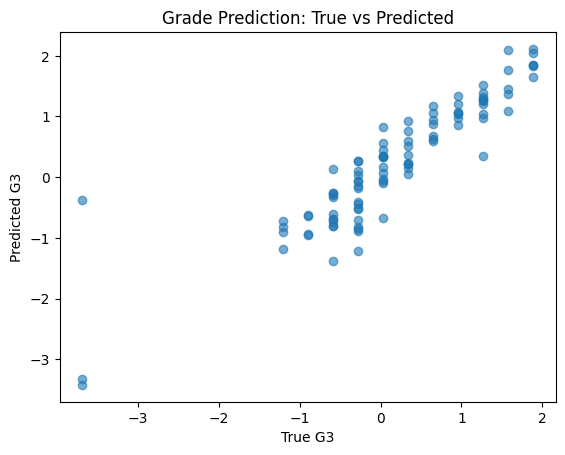

In [ ]:
import matplotlib.pyplot as plt

#  plotting grade prediction score

plt.scatter(y_true_reg, y_pred_reg, alpha=0.6)
plt.xlabel("True G3")
plt.ylabel("Predicted G3")
plt.title("Grade Prediction: True vs Predicted")
plt.show()

